In [1]:
import os
import sys
HOME_DIR='G:'+os.sep+'My Drive'+os.sep+'SECRET-ITN'+os.sep+'Projects'+os.sep+'network_signing'+os.sep
sys.path.append(HOME_DIR)
from glob_vars import SPECIES, TRAIN_DATA, PERT_MAP, LBL_DIR,EDGES_DIR,\
    FT_DIR, SIGNAL_DIR, MOD_DIR, PRT_DIR, NET_DIR,  NET_FILE,\
    PROPAGATE_ALPHA, PROPAGATE_EPSILON ,PROPAGATE_ITERATIONS, DICT_DIR,\
    DICT_FILE, get_terms, get_anchors
import pickle
import collections
import itertools
import lxml.etree as etree
import os
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
print(SPECIES)
print(TRAIN_DATA)
print(PERT_MAP)

S_cerevisiae
['patkar_kegg', 'kpi', 'ubinet2']
Kemmeren


In [2]:

with open( DICT_DIR+DICT_FILE, 'rb') as f:
    alias_2geneid = pickle.load(f)
geneid2alias ={y:x for (x,y) in alias_2geneid.items()}

FILENAME = 'TLM_all_KOterms.edges_'+PERT_MAP+'._patkar_kegg_kpi_ubinet2_'+PERT_MAP+'.sgnl'#'TLM_all_KOterms_850696'#
SIGNAL_scores=pd.read_csv(SIGNAL_DIR+FILENAME, sep=' ', header=None, names=['id1','id2','SIGNAL'])
SIGNAL_scores

,id1,id2,SIGNAL
0,854198,855203,0.562143
1,854198,851259,0.470000
2,856351,851485,0.462000
3,856351,853064,0.510000
4,856351,851263,0.470000
...,...,...,...
592,851174,852190,0.565000
593,851174,855471,0.541667
594,851174,851259,0.520000
595,856163,856657,0.520000


# all TLM data edges SIGNAL scores distribution

<Axes: >

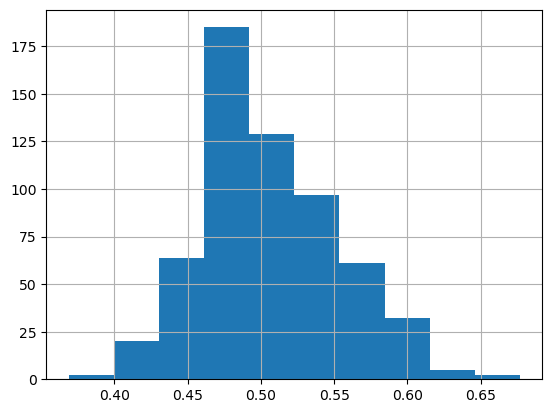

In [3]:
SIGNAL_scores.SIGNAL.hist()

## comparison, SIGNAL training data SIGNAL score distribution

<Axes: >

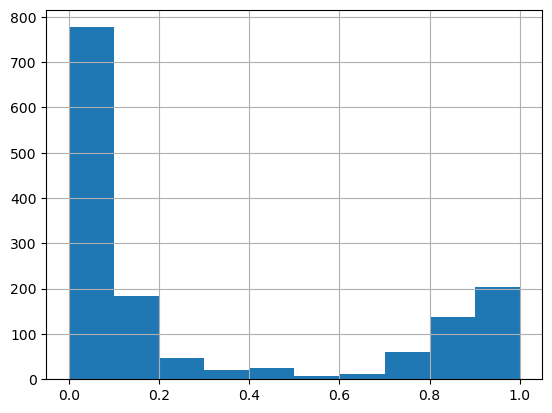

In [4]:
train_SIGNAL = pd.read_csv(SIGNAL_DIR+'alltrain_patkar_kegg_kpi_ubinet2_Kemmeren.sgnl',sep=' ', header=None)
train_SIGNAL[2].hist()

In [5]:
SIGNAL_scores['SIGNAL'].describe()

count    597.000000
mean       0.506921
std        0.046408
min        0.369000
25%        0.480000
50%        0.500000
75%        0.540000
max        0.676667
Name: SIGNAL, dtype: float64

# Compare to experimental data:

    -1 re map genes names to 1) ANCHORS, 2) TERMINALS 3) OTHER
    -2 Make subnetworks of Anchor - terminals (it can be 1 : 1, one term to all anchors, or 1 anchor to all same labeled terminals (MAKES the msot sense, start with this)
        currently are subpaths of all_terms
    -3 LABEL PHENOTYPE OF SUbnetworks based on terminals
    -3.5 Plot them on cytoscape adding THE SIGNAL information and the FEATURE information

    -4 obtain a score (using same method of KO blabla)
    -5 CV on that score to the expected labels

# Usage:
      - step 1: Features creation:
    
       SIGNAL_ft_gen_iterative.py can be called in two main ways to generate features:
            1.from the command line 
  `python SIGNAL_ft_gen_iterative.py -s S_cerevisiae -e edges_file -n network_file -p perturbations_file`
   
           2. import functions in a different python script by:
   `from SIGNAL_ft_gen_iterative import generate_similarity_matrix_wrapper, generate_features_different_knockouts_iterative`
      for multi-threading option, use SIGNAL_ft_gen_parallel.py and import generate_features_different_knockouts function

In [6]:
TERMS=get_terms()
ANCHORS=get_anchors()
print(len(TERMS), len(ANCHORS))

457 12


In [7]:
# map back anchors and terms to genes
# make sure they re there (some terms are left out due to anat max input size)
ALL_GENES = np.unique(list(SIGNAL_scores['id1'])+list(SIGNAL_scores['id2']))
len(ALL_GENES)


460

In [8]:
for anchor in ANCHORS:
    anchorid=alias_2geneid[anchor] 
    if not anchorid in ALL_GENES:
        print(anchor, anchorid)

TEN1 850696


TEN1 missing because disconnected from the rest of ANAT network

In [9]:
t=0
TERMS2=[]
for term in TERMS:
    termid=alias_2geneid[term]
    if term == 'ELO3':
        print(termid)
    if not termid in ALL_GENES:
        print(term, termid)
    else:
        t+=1
        TERMS2.append(term)
print(t)
TERMS=TERMS2 # only use terms actually used (VALE SOLO PER TLM_ALL_KOTERMS)
    

TEN1 850696
YBR284W 852587
YBR292C 852595
YDL119C 851439
YDR115W 851692
YDR532C 852145
YEL057C 856653
YGL039W 852844
YGR042W 852933
YHL012W 856374
YIL042C 854769
YIL077C 854733
YJR079W 853542
YMR269W 855311
YOR008C-A 854171
YOR066W 854232
YOR235W 854410
YPL017C 856090
YPL041C 856066
YPL068C 856037
YPL105C 855999
YPL144W 855959
435


In [10]:
for term in TERMS:
    if term in ANCHORS:
        print(term)

CDC13
EST1
EST2
EST3
RAP1
RIF1
RIF2
STN1
STN1
YKU70
YKU80


In [11]:
# sono i 12 anchors, non sono stati contati come terminals da anat aoutomaticamente

In [12]:
# map to anchor and term etc
id2name = {alias_2geneid[gene]:gene for gene in ANCHORS+TERMS}
def renamegene(x):
    if x in id2name.keys():
        return id2name[x]
    return x

def label(x):
    if x in ANCHORS:
        return('A')
    if x in TERMS:
        return('T')
    else:
        return('O')

SIGNAL_scores['name1'] = SIGNAL_scores['id1'].apply( lambda x: renamegene(x))
SIGNAL_scores['name2'] = SIGNAL_scores['id2'].apply( lambda x: renamegene(x))
SIGNAL_scores['name1lbl'] = SIGNAL_scores['name1'].apply( lambda x: label(x))
SIGNAL_scores['name2lbl'] = SIGNAL_scores['name2'].apply( lambda x: label(x))

In [13]:
SIGNAL_scores

,id1,id2,SIGNAL,name1,name2,name1lbl,name2lbl
0,854198,855203,0.562143,EXO1,MLH1,A,T
1,854198,851259,0.470000,EXO1,851259,A,O
2,856351,851485,0.462000,856351,BRE1,O,T
3,856351,853064,0.510000,856351,NSR1,O,T
4,856351,851263,0.470000,856351,NUP60,O,T
...,...,...,...,...,...,...,...
592,851174,852190,0.565000,RIF2,TEL1,A,T
593,851174,855471,0.541667,RIF2,RAD50,A,T
594,851174,851259,0.520000,RIF2,851259,A,O
595,856163,856657,0.520000,MAK3,MAK10,T,T


# Extract SIGNAL values for all paths


In [14]:
def generate_edges_from_path(path):
    edges=[]
    first=True
    i=0
    for j in path:
        if first:
          first=False
        else:
            edges.append((i,j))
        i=j
    return edges

In [15]:
ANAT_net = nx.from_pandas_edgelist(SIGNAL_scores, 'name1','name2','SIGNAL') # turn to network

In [16]:
len(ANAT_net.edges)

597

Do you like nested for loops?

In [17]:
#USE SIGNAL_of to use all PATHWASY, use SIGNAL_of_avg to use only avg

SIGNAL_of = {}
SIGNAL_of_avg = {}

for anchor in ANCHORS:
    if not anchor == 'TEN1': # disconnected from net
        for term in TERMS:
            print('anchor',anchor,'term',term)
            paths = list(nx.all_shortest_paths(ANAT_net, anchor, term))
            
                        
            # Extract SIGNAL values for all paths
            allSIGNALS=np.zeros((len(paths),len(paths[0])-1))
            for i, path in enumerate(paths):
                edges = generate_edges_from_path(path)
                SIGNALs=[ANAT_net.edges[edge]['SIGNAL'] for edge in edges]
                allSIGNALS[i]=SIGNALs
            SIGNAL_of[(anchor,term)]= allSIGNALS 
            avgSIGNALS=allSIGNALS.mean(axis=0) # take per-edge mean of all paths
            SIGNAL_of_avg[(anchor,term)]= avgSIGNALS
            print('avgSIGNALS',avgSIGNALS)

    
        

anchor EST1 term AAR2
avgSIGNALS [0.47166667 0.49      ]
anchor EST1 term ADE12
avgSIGNALS [0.54 0.49 0.48]
anchor EST1 term ADO1
avgSIGNALS [0.49166667 0.51833333 0.48       0.47333333]
anchor EST1 term AGP2
avgSIGNALS [0.52066667 0.49566667 0.52566667 0.50166667]
anchor EST1 term AHC2
avgSIGNALS [0.51783333 0.50733333 0.4815     0.48166667]
anchor EST1 term ALA1
avgSIGNALS [0.54       0.48666667]
anchor EST1 term APC4
avgSIGNALS [0.54 0.52]
anchor EST1 term APE3
avgSIGNALS [0.52083333 0.49125    0.495625   0.525     ]
anchor EST1 term RAD27
avgSIGNALS [0.52196078 0.49392157 0.48215686 0.47343137]
anchor EST1 term ARC15
avgSIGNALS [0.54       0.49333333 0.50166667]
anchor EST1 term ARC35
avgSIGNALS [0.54       0.49333333 0.46      ]
anchor EST1 term ARD1
avgSIGNALS [0.52785714 0.4747619  0.48309524 0.47      ]
anchor EST1 term ARF1
avgSIGNALS [0.52785714 0.4747619  0.48309524 0.43666667]
anchor EST1 term ARG2
avgSIGNALS [0.54       0.46875    0.5475     0.48916667 0.54666667]
anchor E

avgSIGNALS [0.52166667 0.53       0.5        0.535      0.66       0.635     ]
anchor EST1 term RFA1
avgSIGNALS [0.52791667 0.49958333 0.48125    0.50875    0.52380952 0.52833333]
anchor EST1 term RFA2
avgSIGNALS [0.52232394 0.49411972 0.49058685 0.4879108  0.49043427 0.59666667]
anchor EST1 term RFM1
avgSIGNALS [0.52368056 0.49503472 0.49354167 0.49798611 0.47666667 0.48
 0.49      ]
anchor EST1 term RGR1
avgSIGNALS [0.52296875 0.49408854 0.4940625  0.49348958 0.49458333 0.56666667
 0.48      ]
anchor EST1 term RIF1
avgSIGNALS [0.52166667 0.53       0.5        0.535     ]
anchor EST1 term RIF2
avgSIGNALS [0.55166667 0.54166667]
anchor EST1 term RNA14
avgSIGNALS [0.54       0.47333333 0.59333333 0.55166667 0.58166667]
anchor EST1 term RNA15
avgSIGNALS [0.52083333 0.49125    0.495625   0.58      ]
anchor EST1 term RNH201
avgSIGNALS [0.52166667 0.53       0.5        0.555      0.44233333 0.47416667]
anchor EST1 term RNR1
avgSIGNALS [0.52083333 0.49125    0.495625   0.485     ]
anchor EST

avgSIGNALS [0.49333333 0.55       0.525      0.49333333]
anchor EST2 term ARV1
avgSIGNALS [0.455 0.53  0.47 ]
anchor EST2 term ASC1
avgSIGNALS [0.455 0.51  0.485 0.465 0.53 ]
anchor EST2 term ATC1
avgSIGNALS [0.455 0.53  0.555]
anchor EST2 term MAK3
avgSIGNALS [0.455 0.53  0.48 ]
anchor EST2 term SPP382
avgSIGNALS [0.455 0.51  0.485 0.465 0.45 ]
anchor EST2 term BBP1
avgSIGNALS [0.455      0.40416667 0.51983333]
anchor EST2 term BEM2
avgSIGNALS [0.49333333 0.55       0.525      0.46666667]
anchor EST2 term BEM4
avgSIGNALS [0.49333333 0.55       0.525      0.52      ]
anchor EST2 term BRE1
avgSIGNALS [0.455      0.53       0.4797619  0.48107018 0.462     ]
anchor EST2 term BRE2
avgSIGNALS [0.455      0.40416667 0.52166667 0.55416667 0.42416667 0.51      ]
anchor EST2 term BRO1
avgSIGNALS [0.455      0.51       0.485      0.42666667]
anchor EST2 term BUD16
avgSIGNALS [0.455      0.53       0.515      0.50833333]
anchor EST2 term BUD21
avgSIGNALS [0.53166667 0.59       0.52       0.431666

avgSIGNALS [0.455 0.465]
anchor EST2 term SPT21
avgSIGNALS [0.455      0.53       0.53666667]
anchor EST2 term SRB2
avgSIGNALS [0.455      0.53       0.48       0.54833333 0.56666667]
anchor EST2 term SRB5
avgSIGNALS [0.455      0.53       0.48       0.54833333 0.56666667 0.49333333]
anchor EST2 term SRB8
avgSIGNALS [0.53166667 0.59       0.47166667 0.53      ]
anchor EST2 term SSE1
avgSIGNALS [0.49333333 0.55       0.525      0.48      ]
anchor EST2 term SSH1
avgSIGNALS [0.455      0.53       0.48166667]
anchor EST2 term SSN2
avgSIGNALS [0.53166667 0.59       0.47166667]
anchor EST2 term SSN3
avgSIGNALS [0.53166667 0.59       0.47166667 0.49666667]
anchor EST2 term SSN8
avgSIGNALS [0.53166667 0.59       0.47166667 0.54      ]
anchor EST2 term STN1
avgSIGNALS [0.455      0.53       0.55333333 0.46166667]
anchor EST2 term STO1
avgSIGNALS [0.53166667 0.59       0.48166667 0.48      ]
anchor EST2 term STP22
avgSIGNALS [0.455      0.53       0.515      0.50833333 0.45166667 0.49
 0.5      

avgSIGNALS [0.525      0.48208514 0.47950505 0.49368687]
anchor EST3 term HFI1
avgSIGNALS [0.525      0.4852381  0.47738095 0.49833333]
anchor EST3 term HIT1
avgSIGNALS [0.525      0.54125    0.49833333 0.50333333]
anchor EST3 term HMO1
avgSIGNALS [0.525      0.49       0.47666667 0.51214286]
anchor EST3 term HPR1
avgSIGNALS [0.525      0.4852381  0.47738095 0.48      ]
anchor EST3 term HRT1
avgSIGNALS [0.525 0.45 ]
anchor EST3 term HSC82
avgSIGNALS [0.525      0.541      0.51266667 0.47133333]
anchor EST3 term HSP104
avgSIGNALS [0.525      0.495625   0.49125    0.52083333 0.48166667 0.56      ]
anchor EST3 term HSP82
avgSIGNALS [0.525      0.54125    0.49833333]
anchor EST3 term HST1
avgSIGNALS [0.525      0.54       0.46166667 0.47666667 0.48      ]
anchor EST3 term HTL1
avgSIGNALS [0.525      0.54       0.46166667 0.47       0.57      ]
anchor EST3 term PMR1
avgSIGNALS [0.525      0.47633333 0.48166667]
anchor EST3 term ILV5
avgSIGNALS [0.525 0.56 ]
anchor EST3 term IMG2
avgSIGNALS 

avgSIGNALS [0.525      0.48208514 0.47950505 0.45833333]
anchor EST3 term SWA2
avgSIGNALS [0.525      0.4797619  0.48107018 0.48166667]
anchor EST3 term SWD1
avgSIGNALS [0.50916667 0.506875   0.52333333 0.56166667 0.55416667 0.42416667
 0.48      ]
anchor EST3 term SWD3
avgSIGNALS [0.50916667 0.506875   0.52333333 0.56166667 0.55416667 0.42416667
 0.52      ]
anchor EST3 term TAT2
avgSIGNALS [0.525 0.56 ]
anchor EST3 term TBF1
avgSIGNALS [0.50916667 0.506875   0.52333333 0.56166667 0.44233333 0.5       ]
anchor EST3 term TEL1
avgSIGNALS [0.49333333 0.49208333 0.54604167 0.52       0.565     ]
anchor EST3 term TEL2
avgSIGNALS [0.49333333 0.49208333 0.54604167 0.52       0.565      0.54166667]
anchor EST3 term TFP1
avgSIGNALS [0.525 0.56 ]
anchor EST3 term TGS1
avgSIGNALS [0.525 0.46 ]
anchor EST3 term THP2
avgSIGNALS [0.525 0.595]
anchor EST3 term TID3
avgSIGNALS [0.525      0.4852381  0.47738095 0.43666667]
anchor EST3 term TIF1
avgSIGNALS [0.525 0.555]
anchor EST3 term TIF2
avgSIGNALS

avgSIGNALS [0.56883333 0.52298333 0.5145     0.44733333]
anchor YKU70 term MET7
avgSIGNALS [0.57861111 0.53847222 0.51444444 0.48666667]
anchor YKU70 term MFT1
avgSIGNALS [0.56883333 0.52298333 0.5145     0.52266667]
anchor YKU70 term MLH1
avgSIGNALS [0.61       0.47       0.56214286]
anchor YKU70 term MLP2
avgSIGNALS [0.52166667]
anchor YKU70 term MMM1
avgSIGNALS [0.54555556 0.52097222 0.51777778 0.55      ]
anchor YKU70 term MMS21
avgSIGNALS [0.61       0.55       0.45       0.46166667]
anchor YKU70 term MOT2
avgSIGNALS [0.54555556 0.52097222 0.51777778 0.525     ]
anchor YKU70 term MOT3
avgSIGNALS [0.55444444 0.52527778 0.56555556 0.48555556 0.46666667]
anchor YKU70 term MRC1
avgSIGNALS [0.5        0.59       0.47       0.5        0.53380952]
anchor YKU70 term MRE11
avgSIGNALS [0.61       0.52       0.54166667 0.61333333]
anchor YKU70 term MRM2
avgSIGNALS [0.56010417 0.52222917 0.51020833 0.49291667]
anchor YKU70 term MRPL3
avgSIGNALS [0.60375    0.526      0.53166667 0.45       0.4

avgSIGNALS [0.56564815 0.52531481 0.50851852 0.47703704 0.49333333]
anchor YKU70 term NMA2
avgSIGNALS [0.60583333 0.534      0.51944444 0.51388889]
anchor YKU70 term VPS51
avgSIGNALS [0.60375    0.526      0.53166667 0.48166667]
anchor YKU70 term KRE6
avgSIGNALS [0.60375 0.526   0.4875  0.44   ]
anchor YKU70 term RTC1
avgSIGNALS [0.54722222 0.58722222 0.48166667 0.48166667]
anchor YKU70 term AIM4
avgSIGNALS [0.555      0.535      0.53380952 0.51      ]
anchor YKU70 term MED2
avgSIGNALS [0.61       0.55       0.47666667 0.56666667 0.51      ]
anchor YKU70 term GAS1
avgSIGNALS [0.54555556 0.52097222 0.51777778 0.545     ]
anchor YKU70 term SRP40
avgSIGNALS [0.54555556 0.52097222 0.51777778 0.515     ]
anchor YKU70 term NPR3
avgSIGNALS [0.44233333 0.49416667]
anchor YKU70 term KAP120
avgSIGNALS [0.54555556 0.52097222 0.51777778 0.495      0.56583333]
anchor YKU70 term MDY2
avgSIGNALS [0.61       0.45083333]
anchor YKU70 term QCR8
avgSIGNALS [0.58489583 0.53535417 0.51875    0.47979167]
an

avgSIGNALS [0.59333333 0.47333333 0.54       0.45166667 0.48      ]
anchor YKU80 term RPN7
avgSIGNALS [0.59333333 0.47333333 0.54       0.45166667 0.54      ]
anchor YKU80 term RPP1A
avgSIGNALS [0.49       0.54       0.54666667]
anchor YKU80 term RPS10A
avgSIGNALS [0.53821429 0.54035714 0.52238095 0.46333333]
anchor YKU80 term RPS11B
avgSIGNALS [0.49 0.6 ]
anchor YKU80 term RPS14A
avgSIGNALS [0.49  0.555]
anchor YKU80 term RPS16A
avgSIGNALS [0.59333333 0.47333333 0.54       0.52       0.46166667]
anchor YKU80 term RPS16B
avgSIGNALS [0.49  0.565]
anchor YKU80 term RPS17A
avgSIGNALS [0.56708333 0.54625    0.53380952 0.505     ]
anchor YKU80 term RPS17B
avgSIGNALS [0.56708333 0.54625    0.53380952 0.53333333]
anchor YKU80 term RPS18A
avgSIGNALS [0.59333333 0.47333333 0.49333333]
anchor YKU80 term RPS19A
avgSIGNALS [0.49  0.595]
anchor YKU80 term RPS21A
avgSIGNALS [0.49 0.57]
anchor YKU80 term RPS22A
avgSIGNALS [0.59333333 0.47333333 0.53333333]
anchor YKU80 term RPS23A
avgSIGNALS [0.49 0.

avgSIGNALS [0.46166667 0.55333333 0.46      ]
anchor STN1 term SAP155
avgSIGNALS [0.46166667 0.55333333 0.41      ]
anchor STN1 term EST1
avgSIGNALS [0.54       0.52       0.54166667 0.55166667]
anchor STN1 term EST2
avgSIGNALS [0.46166667 0.55333333 0.53       0.455     ]
anchor STN1 term EST3
avgSIGNALS [0.46166667 0.46166667]
anchor STN1 term FAL1
avgSIGNALS [0.50083333 0.55166667 0.50083333 0.57666667]
anchor STN1 term FCP1
avgSIGNALS [0.46166667 0.55333333 0.485     ]
anchor STN1 term FMP26
avgSIGNALS [0.46166667 0.55333333 0.46      ]
anchor STN1 term RPS30B
avgSIGNALS [0.46166667 0.55333333 0.48      ]
anchor STN1 term NSR1
avgSIGNALS [0.54       0.55       0.48166667 0.51      ]
anchor STN1 term MED6
avgSIGNALS [0.54       0.55       0.47666667 0.56666667 0.53      ]
anchor STN1 term FYV6
avgSIGNALS [0.54       0.55       0.49583333 0.48166667]
anchor STN1 term FZO1
avgSIGNALS [0.46166667 0.55333333 0.6       ]
anchor STN1 term GAL11
avgSIGNALS [0.54       0.55       0.47666667

avgSIGNALS [0.46166667 0.55333333 0.50666667]
anchor STN1 term UGO1
avgSIGNALS [0.54       0.55       0.495      0.50833333]
anchor STN1 term UPF3
avgSIGNALS [0.46166667 0.53666667]
anchor STN1 term URE2
avgSIGNALS [0.54       0.45833333]
anchor STN1 term VAM6
avgSIGNALS [0.54 0.56 0.66 0.57]
anchor STN1 term VAM7
avgSIGNALS [0.54       0.56       0.66       0.57       0.57166667]
anchor STN1 term VPS15
avgSIGNALS [0.46166667 0.55333333 0.56      ]
anchor STN1 term VPS20
avgSIGNALS [0.48777778 0.55888889 0.55       0.50305556 0.50833333 0.47608333
 0.4265    ]
anchor STN1 term VPS21
avgSIGNALS [0.46166667 0.55333333 0.52214286]
anchor STN1 term VPS25
avgSIGNALS [0.47733333 0.56666667 0.55166667 0.49333333 0.5        0.45816667]
anchor STN1 term VPS27
avgSIGNALS [0.52041667 0.58583333 0.50166667 0.5425     0.47666667 0.49      ]
anchor STN1 term VPS28
avgSIGNALS [0.47733333 0.56666667 0.55166667 0.49333333 0.5        0.44816667]
anchor STN1 term VPS3
avgSIGNALS [0.54       0.55       0.

avgSIGNALS [0.48166667 0.43833333 0.45      ]
anchor CDC13 term SMD1
avgSIGNALS [0.50875    0.48125    0.49958333 0.52791667 0.48166667]
anchor CDC13 term PRP4
avgSIGNALS [0.48166667 0.43833333 0.45       0.57      ]
anchor CDC13 term PRP43
avgSIGNALS [0.48166667 0.43833333 0.58166667]
anchor CDC13 term PRS3
avgSIGNALS [0.59 0.48]
anchor CDC13 term PRS5
avgSIGNALS [0.48166667 0.48166667 0.52166667 0.43666667]
anchor CDC13 term PSF3
avgSIGNALS [0.47       0.5        0.51214286]
anchor CDC13 term PSY4
avgSIGNALS [0.48166667 0.48166667 0.52166667 0.47666667]
anchor CDC13 term PTC1
avgSIGNALS [0.485      0.45166667 0.50833333 0.49666667]
anchor CDC13 term PUB1
avgSIGNALS [0.50574074 0.49092593 0.48981481 0.52833333]
anchor CDC13 term PXR1
avgSIGNALS [0.48166667 0.43833333 0.58166667 0.46      ]
anchor CDC13 term RAD17
avgSIGNALS [0.419 0.51  0.52 ]
anchor CDC13 term RAD27
avgSIGNALS [0.48166667 0.43833333 0.48166667]
anchor CDC13 term RAD5
avgSIGNALS [0.51261905 0.49357143 0.49261905 0.515

avgSIGNALS [0.47       0.55       0.49583333 0.48166667]
anchor EXO1 term FZO1
avgSIGNALS [0.47       0.55777778 0.50055556 0.56055556]
anchor EXO1 term GAL11
avgSIGNALS [0.47       0.55       0.47666667 0.56666667 0.59      ]
anchor EXO1 term GCD1
avgSIGNALS [0.47       0.55       0.47666667 0.53166667]
anchor EXO1 term PTA1
avgSIGNALS [0.47  0.56  0.66  0.645]
anchor EXO1 term GLO4
avgSIGNALS [0.47       0.54229167 0.51       0.46416667]
anchor EXO1 term GON7
avgSIGNALS [0.47       0.56166667 0.51       0.555     ]
anchor EXO1 term GPB2
avgSIGNALS [0.47       0.55583333 0.49916667 0.47541667]
anchor EXO1 term GPI8
avgSIGNALS [0.47 0.55 0.51 0.48]
anchor EXO1 term GTR1
avgSIGNALS [0.47       0.55583333 0.50625    0.48541667]
anchor EXO1 term GTR2
avgSIGNALS [0.47       0.56166667 0.51       0.575     ]
anchor EXO1 term GUP1
avgSIGNALS [0.47       0.55777778 0.50055556 0.49388889]
anchor EXO1 term GUP2
avgSIGNALS [0.47       0.56833333 0.51722222 0.5025     0.47944444 0.49      ]
ancho

avgSIGNALS [0.47    0.57    0.5675  0.5125  0.525   0.45525 0.494  ]
anchor EXO1 term YOR1
avgSIGNALS [0.47       0.55       0.51       0.45666667]
anchor EXO1 term RFC1
avgSIGNALS [0.47       0.55       0.48       0.47666667]
anchor EXO1 term YPP1
avgSIGNALS [0.47       0.61       0.44233333 0.49666667]
anchor EXO1 term YPT7
avgSIGNALS [0.47       0.56       0.66       0.57       0.52666667]
anchor EXO1 term YSP3
avgSIGNALS [0.47       0.57333333 0.49111111 0.495     ]
anchor EXO1 term YTA7
avgSIGNALS [0.47 0.55 0.48 0.53]
anchor EXO1 term ZEO1
avgSIGNALS [0.47       0.56166667 0.51       0.54      ]
anchor EXO1 term INO80
avgSIGNALS [0.47 0.55 0.48 0.5 ]
anchor EXO1 term HRR25
avgSIGNALS [0.47       0.56166667 0.51       0.51      ]
anchor EXO1 term PDS5
avgSIGNALS [0.47       0.56166667 0.51       0.575     ]
anchor EXO1 term SWC4
avgSIGNALS [0.47       0.615      0.54166667 0.59166667]
anchor EXO1 term RIM2
avgSIGNALS [0.47       0.54229167 0.51       0.46083333]
anchor EXO1 term M

avgSIGNALS [0.50198718 0.50057692 0.49580128 0.52032051 0.49371795 0.49666667]
anchor RAP1 term PRE5
avgSIGNALS [0.50198718 0.50057692 0.49580128 0.52032051 0.49371795]
anchor RAP1 term PRI1
avgSIGNALS [0.48166667 0.43833333 0.48166667 0.47       0.46      ]
anchor RAP1 term PRO1
avgSIGNALS [0.48       0.44666667]
anchor RAP1 term PRP22
avgSIGNALS [0.46166667 0.54       0.6       ]
anchor RAP1 term PRP31
avgSIGNALS [0.48166667 0.45      ]
anchor RAP1 term SMD1
avgSIGNALS [0.49798611 0.49354167 0.49503472 0.52368056 0.48166667]
anchor RAP1 term PRP4
avgSIGNALS [0.48166667 0.45       0.57      ]
anchor RAP1 term PRP43
avgSIGNALS [0.49583333 0.52333333]
anchor RAP1 term PRS3
avgSIGNALS [0.55  0.585 0.505 0.48 ]
anchor RAP1 term PRS5
avgSIGNALS [0.51       0.43666667]
anchor RAP1 term PSF3
avgSIGNALS [0.48166667 0.43833333 0.48166667 0.47       0.5        0.51214286]
anchor RAP1 term PSY4
avgSIGNALS [0.51       0.47666667]
anchor RAP1 term PTC1
avgSIGNALS [0.46166667 0.54       0.515      

avgSIGNALS [0.50198718 0.50057692 0.49580128 0.52032051 0.49371795 0.47666667]
anchor RAP1 term CMK2
avgSIGNALS [0.55       0.50333333]
anchor RAP1 term CPA1
avgSIGNALS [0.55  0.585 0.505 0.46 ]
anchor RAP1 term YPK3
avgSIGNALS [0.49555556 0.48833333]
anchor RAP1 term LSP1
avgSIGNALS [0.46166667 0.54       0.585     ]
anchor RAP1 term UAF30
avgSIGNALS [0.55       0.61       0.44233333 0.46416667]
anchor RAP1 term PXL1
avgSIGNALS [0.48166667 0.48166667]
anchor RAP1 term GDB1
avgSIGNALS [0.5025     0.51333333]
anchor RIF1 term AAR2
avgSIGNALS [0.54625    0.51458333 0.48166667 0.48166667]
anchor RIF1 term ADE12
avgSIGNALS [0.54166667 0.53277778 0.56277778 0.47027778 0.49       0.48      ]
anchor RIF1 term ADO1
avgSIGNALS [0.51       0.47333333]
anchor RIF1 term AGP2
avgSIGNALS [0.54625    0.522      0.50833333 0.50166667]
anchor RIF1 term AHC2
avgSIGNALS [0.54625    0.51458333 0.48166667 0.48166667]
anchor RIF1 term ALA1
avgSIGNALS [0.54166667 0.53277778 0.56277778 0.47027778 0.48666667]


avgSIGNALS [0.5345     0.53683333 0.51533333 0.585     ]
anchor RIF1 term RPL13B
avgSIGNALS [0.5345     0.53683333 0.51533333 0.58      ]
anchor RIF1 term RPL1B
avgSIGNALS [0.535      0.5        0.53       0.52166667 0.52       0.46      ]
anchor RIF1 term RPL34B
avgSIGNALS [0.5325     0.48083333]
anchor RIF1 term RPN12
avgSIGNALS [0.535      0.5        0.53       0.52166667 0.45166667 0.51      ]
anchor RIF1 term RPN4
avgSIGNALS [0.51       0.51333333]
anchor RIF1 term RPN5
avgSIGNALS [0.535      0.5        0.53       0.52166667 0.45166667]
anchor RIF1 term RPN6
avgSIGNALS [0.535      0.5        0.53       0.52166667 0.45166667 0.48      ]
anchor RIF1 term RPN7
avgSIGNALS [0.535      0.5        0.53       0.52166667 0.45166667 0.54      ]
anchor RIF1 term RPP1A
avgSIGNALS [0.56       0.55       0.46166667 0.54666667]
anchor RIF1 term RPS10A
avgSIGNALS [0.51       0.46333333]
anchor RIF1 term RPS11B
avgSIGNALS [0.5345     0.53683333 0.51533333 0.6       ]
anchor RIF1 term RPS14A
avgSIG

avgSIGNALS [0.52       0.56166667 0.51       0.41      ]
anchor RIF2 term EST1
avgSIGNALS [0.54166667 0.55166667]
anchor RIF2 term EST2
avgSIGNALS [0.54166667 0.55166667 0.59       0.53166667]
anchor RIF2 term EST3
avgSIGNALS [0.52       0.54604167 0.49208333 0.49333333]
anchor RIF2 term FAL1
avgSIGNALS [0.52       0.55       0.46166667 0.57666667]
anchor RIF2 term FCP1
avgSIGNALS [0.52       0.56166667 0.51       0.485     ]
anchor RIF2 term FMP26
avgSIGNALS [0.52       0.56866667 0.49566667 0.47833333]
anchor RIF2 term RPS30B
avgSIGNALS [0.52       0.55777778 0.49888889 0.50277778]
anchor RIF2 term NSR1
avgSIGNALS [0.52       0.55       0.48166667 0.51      ]
anchor RIF2 term MED6
avgSIGNALS [0.52       0.55       0.47666667 0.56666667 0.53      ]
anchor RIF2 term FYV6
avgSIGNALS [0.52       0.55       0.49583333 0.48166667]
anchor RIF2 term FZO1
avgSIGNALS [0.52       0.55777778 0.50055556 0.56055556]
anchor RIF2 term GAL11
avgSIGNALS [0.52       0.55       0.47666667 0.56666667 0.5

avgSIGNALS [0.52       0.55583333 0.50291667 0.51208333]
anchor RIF2 term VPS54
avgSIGNALS [0.52       0.55       0.48166667 0.48166667]
anchor RIF2 term VPS75
avgSIGNALS [0.52 0.55 0.48 0.54]
anchor RIF2 term VPS9
avgSIGNALS [0.52       0.55       0.49583333 0.43416667]
anchor RIF2 term VRP1
avgSIGNALS [0.52       0.615      0.54166667 0.60166667]
anchor RIF2 term WHI2
avgSIGNALS [0.52       0.56166667 0.51       0.52      ]
anchor RIF2 term XDJ1
avgSIGNALS [0.52       0.53083333]
anchor RIF2 term XRS2
avgSIGNALS [0.565      0.55333333]
anchor RIF2 term YDJ1
avgSIGNALS [0.54166667 0.55166667 0.54      ]
anchor RIF2 term CDC9
avgSIGNALS [0.52       0.55       0.49583333 0.48083333]
anchor RIF2 term CDC9
avgSIGNALS [0.52       0.55       0.49583333 0.48083333]
anchor RIF2 term NCB2
avgSIGNALS [0.52       0.55       0.54       0.55166667]
anchor RIF2 term HYP2
avgSIGNALS [0.54166667 0.55166667 0.54       0.52      ]
anchor RIF2 term BET4
avgSIGNALS [0.53083333 0.55083333 0.5175     0.525

# Calculate probability of being negative with chain rule

## apply chain rule to SIGNAL_of

In [18]:
def chain_rule(p_minus):
# find all odd indexes <= len(p_minus)

    p_minus=np.array(p_minus)
    cum_prob=0
    n_steps = len(p_minus)
    odd_nums=[number for number in range(n_steps + 1) if number % 2 != 0]
    # odd_nums=[1,3,5]
    for odd_num in odd_nums: 
        # find all combinations of steps with ind (i.e. 3 minuses
        
        minus_list = np.array([-1]*odd_num+[+1]*(n_steps-odd_num))
        #minus_list = ['-', '-', '-', '+', '+']
        
        #find cobinations
        current_combs = set(itertools.permutations(minus_list,n_steps))

        curr_cum_prob=0
        for signs in current_combs:
            # map + to p_plus and - to p_minus
            probs = np.where(np.array(signs)==-1, p_minus, 1-p_minus)
            probs=np.prod(probs)
            curr_cum_prob+=probs
        cum_prob+=curr_cum_prob
    return cum_prob

def p_of_at_least_one_event_happening(list_of_p): 
    # for combinign all AT shortest paths
    return 1-np.prod([1-p for p in list_of_p])

In [19]:
# in the end, choose one out of these four dictionaries.
# first version is pred_phenotype_term_avg

pred_phenotype_term = {} #v1
pred_AT_output ={} # v2 same as above dictionary, but key has also anchor info . leads to worse predictions, use v1
for key, p_minus_list in SIGNAL_of.items():

    print(key)
    # All paths

    out_p_list= []
    for p_minus in p_minus_list:
        p_output=chain_rule(p_minus) # calculate probability of single path having negative output
        out_p_list.append(p_output)
    pred_phenotype_term[key[1]]=p_of_at_least_one_event_happening(out_p_list) # calculate probability of at least one negative outcome path to realize 
    pred_AT_output[key] = p_of_at_least_one_event_happening(out_p_list) #v2
    print('probability of negative output', pred_phenotype_term[key[1]])

pred_phenotype_term_avg = {} #v1
pred_AT_output_avg ={} # v2 same as above dictionary, but key has also anchor info . leads to worse predictions, use v1
for key, p_minus_list in SIGNAL_of_avg.items():
    # average paths
    print('avg')
    p_minus = p_minus_list
    p_output=chain_rule(p_minus)
    pred_phenotype_term_avg[key[1]]=p_output #v1
    pred_AT_output_avg[key] = p_output #v2
    
    print('probability of negative output', pred_phenotype_term[key[1]])

('EST1', 'AAR2')
probability of negative output 0.4994333333333333
('EST1', 'ADE12')
probability of negative output 0.500032
('EST1', 'ADO1')
probability of negative output 0.5000006518518518
('EST1', 'AGP2')
probability of negative output 0.9687500860224598
('EST1', 'AHC2')
probability of negative output 0.999023407027887
('EST1', 'ALA1')
probability of negative output 0.5010666666666667
('EST1', 'APC4')
probability of negative output 0.49839999999999995
('EST1', 'APE3')
probability of negative output 0.9960937693596265
('EST1', 'RAD27')
probability of negative output 0.9999923711566594
('EST1', 'ARC15')
probability of negative output 0.49999822222222223
('EST1', 'ARC35')
probability of negative output 0.5000426666666666
('EST1', 'ARD1')
probability of negative output 0.9921881324856064
('EST1', 'ARF1')
probability of negative output 0.9921888352136293
('EST1', 'ARG2')
probability of negative output 0.7499995054198205
('EST1', 'ARP2')
probability of negative output 0.49992088888888886

probability of negative output 1.0
('EST1', 'MET18')
probability of negative output 0.9999999701962654
('EST1', 'MET7')
probability of negative output 0.7500001413086474
('EST1', 'MFT1')
probability of negative output 0.9999999701985176
('EST1', 'MLH1')
probability of negative output 0.49999871571428556
('EST1', 'MLP2')
probability of negative output 0.8749700510656034
('EST1', 'MMM1')
probability of negative output 0.9960937887232283
('EST1', 'MMS21')
probability of negative output 0.9999999403953092
('EST1', 'MOT2')
probability of negative output 0.9960937693596265
('EST1', 'MOT3')
probability of negative output 0.5026666666666667
('EST1', 'MRC1')
probability of negative output 0.9375
('EST1', 'MRE11')
probability of negative output 0.4882888888888889
('EST1', 'MRM2')
probability of negative output 0.5016
('EST1', 'MRPL3')
probability of negative output 0.99902343417578
('EST1', 'KKQ8')
probability of negative output 0.9997558593799888
('EST1', 'MRPL44')
probability of negative outpu

probability of negative output 0.9999999403954057
('EST1', 'RSC4')
probability of negative output 0.9999999403954177
('EST1', 'RSC8')
probability of negative output 0.9999999403949944
('EST1', 'RTF1')
probability of negative output 0.9374999999320203
('EST1', 'SAD1')
probability of negative output 0.9960937809773105
('EST1', 'SAH1')
probability of negative output 0.9960937732320289
('EST1', 'SAM35')
probability of negative output 0.9375000000016042
('EST1', 'SAP30')
probability of negative output 0.9999694829384049
('EST1', 'SEC20')
probability of negative output 0.9999923712596023
('EST1', 'SEC63')
probability of negative output 0.9921890460251063
('EST1', 'SEM1')
probability of negative output 0.4971
('EST1', 'SEN54')
probability of negative output 0.5000238240740741
('EST1', 'SET1')
probability of negative output 0.7500003112677469
('EST1', 'SHP1')
probability of negative output 0.7499994646755423
('EST1', 'SIF2')
probability of negative output 0.9999923709850863
('EST1', 'SIN3')
pr

probability of negative output 0.9999999997671694
('EST1', 'GAS1')
probability of negative output 0.9960937848501898
('EST1', 'SRP40')
probability of negative output 0.9960937616152988
('EST1', 'NPR3')
probability of negative output 0.7499999745091974
('EST1', 'KAP120')
probability of negative output 0.9960937505097526
('EST1', 'MDY2')
probability of negative output 0.5000169351851852
('EST1', 'QCR8')
probability of negative output 0.999023407027887
('EST1', 'RSC1')
probability of negative output 0.9999999403954105
('EST1', 'LOS1')
probability of negative output 0.9960937504645845
('EST1', 'PPQ1')
probability of negative output 0.9960937887232283
('EST1', 'FUB1')
probability of negative output 0.4996111111111111
('EST1', 'CMK2')
probability of negative output 0.9980468821310874
('EST1', 'CPA1')
probability of negative output 0.5000009777777777
('EST1', 'YPK3')
probability of negative output 0.9999997615968055
('EST1', 'LSP1')
probability of negative output 0.998046907601193
('EST1', 'U

probability of negative output 0.9960937499774585
('EST2', 'LRP1')
probability of negative output 0.49999054
('EST2', 'LSM7')
probability of negative output 0.4997299999999999
('EST2', 'LSM8')
probability of negative output 0.49999163999999996
('EST2', 'LST7')
probability of negative output 0.500162
('EST2', 'MAK10')
probability of negative output 0.49999567999999994
('EST2', 'MAK21')
probability of negative output 0.5000182400000001
('EST2', 'MAK31')
probability of negative output 0.49999567999999994
('EST2', 'MCD4')
probability of negative output 0.49997457624999997
('EST2', 'MCM3')
probability of negative output 0.99609375
('EST2', 'MCM6')
probability of negative output 0.99609375
('EST2', 'MDM10')
probability of negative output 0.996093750162835
('EST2', 'MDN1')
probability of negative output 0.7500044980888969
('EST2', 'MEC1')
probability of negative output 0.9960937493107515
('EST2', 'MED1')
probability of negative output 0.7500011837081415
('EST2', 'MET18')
probability of negati

probability of negative output 0.9960937499962005
('EST2', 'SAP30')
probability of negative output 0.499784
('EST2', 'SEC20')
probability of negative output 0.50000234
('EST2', 'SEC63')
probability of negative output 0.50000396
('EST2', 'SEM1')
probability of negative output 0.49996693999999997
('EST2', 'SEN54')
probability of negative output 0.8749967455262042
('EST2', 'SET1')
probability of negative output 0.49999385907986094
('EST2', 'SHP1')
probability of negative output 0.5000011806079999
('EST2', 'SIF2')
probability of negative output 0.50000162
('EST2', 'SIN3')
probability of negative output 0.7499971590988952
('EST2', 'SIR3')
probability of negative output 0.8750001189999922
('EST2', 'SIR4')
probability of negative output 0.8749997917499763
('EST2', 'SIT4')
probability of negative output 0.9999980926621798
('EST2', 'SIW14')
probability of negative output 0.9999980926621798
('EST2', 'SLA2')
probability of negative output 0.749999036400159
('EST2', 'SLI15')
probability of negativ

probability of negative output 0.9960937499456656
('EST3', 'BRO1')
probability of negative output 0.9999999998835862
('EST3', 'BUD16')
probability of negative output 0.5000125
('EST3', 'BUD21')
probability of negative output 0.9960937498941783
('EST3', 'BUD23')
probability of negative output 0.49949999999999994
('EST3', 'BUD32')
probability of negative output 0.5001925
('EST3', 'CAX4')
probability of negative output 0.5
('EST3', 'CBC2')
probability of negative output 0.9960937499716088
('EST3', 'CBF5')
probability of negative output 0.9960937507097828
('EST3', 'CCW14')
probability of negative output 0.497
('EST3', 'CDC13')
probability of negative output 0.9921877680404964
('EST3', 'CDC16')
probability of negative output 0.9999980927514818
('EST3', 'CDC19')
probability of negative output 0.9374993000348444
('EST3', 'CDC21')
probability of negative output 0.7500006814830822
('EST3', 'CDC34')
probability of negative output 0.7481452777777777
('EST3', 'CDC45')
probability of negative outpu

probability of negative output 0.9960937499122454
('EST3', 'OGG1')
probability of negative output 0.9980468966979752
('EST3', 'OPI1')
probability of negative output 0.5000003111111111
('EST3', 'ORC5')
probability of negative output 0.7500001703704704
('EST3', 'PAF1')
probability of negative output 0.9921874996421973
('EST3', 'PBP2')
probability of negative output 0.502
('EST3', 'PCL6')
probability of negative output 0.9999980927514818
('EST3', 'PCP1')
probability of negative output 0.49650000000000005
('EST3', 'PDX3')
probability of negative output 0.5025000000000001
('EST3', 'PEP3')
probability of negative output 0.9921875009333114
('EST3', 'PFD1')
probability of negative output 0.50005
('EST3', 'PGD1')
probability of negative output 0.497
('EST3', 'PHO80')
probability of negative output 0.5000118222222223
('EST3', 'PHO85')
probability of negative output 0.4999066666666666
('EST3', 'PHO87')
probability of negative output 0.9999694832729666
('EST3', 'PHO88')
probability of negative out

probability of negative output 0.996093749891331
('EST3', 'TAT2')
probability of negative output 0.497
('EST3', 'TBF1')
probability of negative output 0.99609375
('EST3', 'TEL1')
probability of negative output 0.9375001090075543
('EST3', 'TEL2')
probability of negative output 0.9374999909160504
('EST3', 'TFP1')
probability of negative output 0.497
('EST3', 'TGS1')
probability of negative output 0.502
('EST3', 'THP2')
probability of negative output 0.49524999999999997
('EST3', 'TID3')
probability of negative output 0.9999389627569447
('EST3', 'TIF1')
probability of negative output 0.49724999999999997
('EST3', 'TIF2')
probability of negative output 0.49575
('EST3', 'TLC1')
probability of negative output 0.50000855
('EST3', 'TOM5')
probability of negative output 0.5000005902777778
('EST3', 'TOP3')
probability of negative output 0.9999998807972537
('EST3', 'TPD3')
probability of negative output 0.7500010222258237
('EST3', 'TRK1')
probability of negative output 0.49875
('EST3', 'TRS20')
pro

probability of negative output 0.7496138970666666
('YKU70', 'CSR2')
probability of negative output 0.874999475185704
('YKU70', 'CST6')
probability of negative output 0.4999648
('YKU70', 'CTF18')
probability of negative output 0.9960948764698269
('YKU70', 'CTF8')
probability of negative output 0.996093656118913
('YKU70', 'CTK1')
probability of negative output 0.9960934849874539
('YKU70', 'CYC8')
probability of negative output 0.7499890804104771
('YKU70', 'DAD2')
probability of negative output 0.9843789928230017
('YKU70', 'DCC1')
probability of negative output 0.99609375
('YKU70', 'DDC1')
probability of negative output 0.5
('YKU70', 'DEP1')
probability of negative output 0.5088422222222222
('YKU70', 'DIG1')
probability of negative output 0.8749974006794861
('YKU70', 'DOA4')
probability of negative output 0.9687500094305445
('YKU70', 'DUN1')
probability of negative output 0.9960939022782953
('YKU70', 'EAP1')
probability of negative output 0.9843784937455621
('YKU70', 'EBS1')
probability o

probability of negative output 0.9843794918931741
('YKU70', 'RPS23B')
probability of negative output 0.9843735025714637
('YKU70', 'RPS27B')
probability of negative output 0.9843804900117169
('YKU70', 'RPS28B')
probability of negative output 0.9843792423589963
('YKU70', 'RPS31')
probability of negative output 0.9843774955688808
('YKU70', 'RPS4A')
probability of negative output 0.7499717352380952
('YKU70', 'RPS4B')
probability of negative output 0.9843789928230017
('YKU70', 'RPT3')
probability of negative output 0.49995049999999996
('YKU70', 'RPT5')
probability of negative output 0.749999987791358
('YKU70', 'STN1')
probability of negative output 0.49119999999999997
('YKU70', 'RSA1')
probability of negative output 0.8750009902144217
('YKU70', 'RSC2')
probability of negative output 0.5000924
('YKU70', 'RSC4')
probability of negative output 0.5001144000000001
('YKU70', 'RSC8')
probability of negative output 0.49934
('YKU70', 'RTF1')
probability of negative output 0.5
('YKU70', 'SAD1')
proba

probability of negative output 0.5000002666666666
('STN1', 'HIT1')
probability of negative output 0.9687499642666743
('STN1', 'HMO1')
probability of negative output 0.5000038857142857
('STN1', 'HPR1')
probability of negative output 0.5000032000000001
('STN1', 'HRT1')
probability of negative output 0.5004088888888889
('STN1', 'HSC82')
probability of negative output 0.5
('STN1', 'HSP104')
probability of negative output 0.5000000606222221
('STN1', 'HSP82')
probability of negative output 0.9687553601707273
('STN1', 'HST1')
probability of negative output 0.49999253333333327
('STN1', 'HTL1')
probability of negative output 0.5000336
('STN1', 'PMR1')
probability of negative output 0.499648
('STN1', 'ILV5')
probability of negative output 0.49950933333333336
('STN1', 'IMG2')
probability of negative output 0.9374949504969877
('STN1', 'IPK2')
probability of negative output 0.5000179911111111
('STN1', 'ISA1')
probability of negative output 0.4999992192592593
('STN1', 'KAE1')
probability of negative

probability of negative output 0.96875
('STN1', 'SOH1')
probability of negative output 0.750004777858086
('STN1', 'SOL2')
probability of negative output 0.49977472
('STN1', 'SPN1')
probability of negative output 0.5000817777777777
('STN1', 'SPS100')
probability of negative output 0.4999828266666667
('STN1', 'SPT21')
probability of negative output 0.4997001481481481
('STN1', 'SRB2')
probability of negative output 0.500024888888889
('STN1', 'SRB5')
probability of negative output 0.5000003318518519
('STN1', 'SRB8')
probability of negative output 0.5000000468444443
('STN1', 'SSE1')
probability of negative output 0.9687502144002732
('STN1', 'SSH1')
probability of negative output 0.5001499259259259
('STN1', 'SSN2')
probability of negative output 0.4999992192592593
('STN1', 'SSN3')
probability of negative output 0.49999999479506174
('STN1', 'SSN8')
probability of negative output 0.5000000624592592
('STN1', 'STO1')
probability of negative output 0.4999999797925925
('STN1', 'STP22')
probability

probability of negative output 0.9960937644742153
('CDC13', 'EST3')
probability of negative output 0.9921877680404964
('CDC13', 'FAL1')
probability of negative output 0.9960937247345788
('CDC13', 'FCP1')
probability of negative output 0.9921873391751342
('CDC13', 'FMP26')
probability of negative output 0.4993277777777778
('CDC13', 'RPS30B')
probability of negative output 0.9921872855667511
('CDC13', 'NSR1')
probability of negative output 0.5000452222222223
('CDC13', 'MED6')
probability of negative output 0.4999999690479011
('CDC13', 'FYV6')
probability of negative output 0.49991709259259265
('CDC13', 'FZO1')
probability of negative output 0.49991709259259265
('CDC13', 'GAL11')
probability of negative output 0.4999999071437037
('CDC13', 'GCD1')
probability of negative output 0.5000002450374486
('CDC13', 'PTA1')
probability of negative output 0.49983296
('CDC13', 'GLO4')
probability of negative output 0.7500048749808386
('CDC13', 'GON7')
probability of negative output 0.99218808968753
('

probability of negative output 0.9960937612577236
('CDC13', 'SPT21')
probability of negative output 0.9921878931256564
('CDC13', 'SRB2')
probability of negative output 0.5000005158683127
('CDC13', 'SRB5')
probability of negative output 0.5000000068782442
('CDC13', 'SRB8')
probability of negative output 0.9375000000207778
('CDC13', 'SSE1')
probability of negative output 0.7499989244432876
('CDC13', 'SSH1')
probability of negative output 0.4993277777777778
('CDC13', 'SSN2')
probability of negative output 0.9374999996537112
('CDC13', 'SSN3')
probability of negative output 0.9374999999976914
('CDC13', 'SSN8')
probability of negative output 0.9375000000277037
('CDC13', 'STO1')
probability of negative output 0.9374999999910371
('CDC13', 'STP22')
probability of negative output 0.5
('CDC13', 'SUA5')
probability of negative output 0.9980468321486528
('CDC13', 'SUM1')
probability of negative output 0.4999095555555556
('CDC13', 'SUR4')
probability of negative output 0.49991709259259265
('CDC13', 

probability of negative output 0.75000660001728
('EXO1', 'HSC82')
probability of negative output 0.5
('EXO1', 'HSP104')
probability of negative output 0.49999995453333335
('EXO1', 'HSP82')
probability of negative output 0.49992832
('EXO1', 'HST1')
probability of negative output 0.5000056
('EXO1', 'HTL1')
probability of negative output 0.49997479999999994
('EXO1', 'PMR1')
probability of negative output 0.5002639999999999
('EXO1', 'ILV5')
probability of negative output 0.7499920800248832
('EXO1', 'IMG2')
probability of negative output 0.937503786928863
('EXO1', 'IPK2')
probability of negative output 0.7500002904000335
('EXO1', 'ISA1')
probability of negative output 0.5000005855555556
('EXO1', 'KAE1')
probability of negative output 0.7500002904000335
('EXO1', 'KCS1')
probability of negative output 0.5000033450666667
('EXO1', 'KEM1')
probability of negative output 0.4999999848444443
('EXO1', 'KRE33')
probability of negative output 0.5000051999999999
('EXO1', 'KRS1')
probability of negative

probability of negative output 0.7499894400442368
('EXO1', 'RPL1B')
probability of negative output 0.4999999669333335
('EXO1', 'RPL34B')
probability of negative output 0.9374962129010836
('EXO1', 'RPN12')
probability of negative output 0.49999998002222223
('EXO1', 'RPN4')
probability of negative output 0.7500009599999999
('EXO1', 'RPN5')
probability of negative output 0.5000009988888887
('EXO1', 'RPN6')
probability of negative output 0.5000000399555555
('EXO1', 'RPN7')
probability of negative output 0.49999992008888894
('EXO1', 'RPP1A')
probability of negative output 0.4999785333333333
('EXO1', 'RPS10A')
probability of negative output 0.7499973600000001
('EXO1', 'RPS11B')
probability of negative output 0.74998680006912
('EXO1', 'RPS14A')
probability of negative output 0.7499927400209088
('EXO1', 'RPS16A')
probability of negative output 0.49999996831111115
('EXO1', 'RPS16B')
probability of negative output 0.7499914200292033
('EXO1', 'RPS17A')
probability of negative output 0.50000243428

probability of negative output 0.999999940395364
('RAP1', 'CBF5')
probability of negative output 0.9999999403951347
('RAP1', 'CCW14')
probability of negative output 0.49963199999999997
('RAP1', 'CDC13')
probability of negative output 0.49991709259259265
('RAP1', 'CDC16')
probability of negative output 0.4993277777777778
('RAP1', 'CDC19')
probability of negative output 0.9990234900330042
('RAP1', 'CDC21')
probability of negative output 0.7499984
('RAP1', 'CDC34')
probability of negative output 0.49938666666666665
('RAP1', 'CDC45')
probability of negative output 0.5000000000000001
('RAP1', 'CDC73')
probability of negative output 0.5000001721555734
('RAP1', 'CDC8')
probability of negative output 0.984375
('RAP1', 'CDH1')
probability of negative output 0.5000566133333334
('RAP1', 'CGI121')
probability of negative output 0.49999325333333333
('RAP1', 'CHO2')
probability of negative output 0.7501425768062222
('RAP1', 'CMD1')
probability of negative output 0.49996663333333335
('RAP1', 'COG3')


probability of negative output 0.9999999403954017
('RAP1', 'RPP1A')
probability of negative output 0.5035777777777778
('RAP1', 'RPS10A')
probability of negative output 0.7500044
('RAP1', 'RPS11B')
probability of negative output 0.49938666666666665
('RAP1', 'RPS14A')
probability of negative output 0.4996626666666666
('RAP1', 'RPS16A')
probability of negative output 0.9999999403953737
('RAP1', 'RPS16B')
probability of negative output 0.49960133333333334
('RAP1', 'RPS17A')
probability of negative output 0.4999959428571429
('RAP1', 'RPS17B')
probability of negative output 0.4999729523809524
('RAP1', 'RPS18A')
probability of negative output 0.9990234450048071
('RAP1', 'RPS19A')
probability of negative output 0.49941733333333327
('RAP1', 'RPS21A')
probability of negative output 0.4995706666666666
('RAP1', 'RPS22A')
probability of negative output 0.9990233999755029
('RAP1', 'RPS23A')
probability of negative output 0.499448
('RAP1', 'RPS23B')
probability of negative output 0.9375240829438238
(

probability of negative output 0.968753028600347
('RIF1', 'DCC1')
probability of negative output 0.984375
('RIF1', 'DDC1')
probability of negative output 0.500005832
('RIF1', 'DEP1')
probability of negative output 0.7501167173333333
('RIF1', 'DIG1')
probability of negative output 0.8749986702530375
('RIF1', 'DOA4')
probability of negative output 0.9687500052047755
('RIF1', 'DUN1')
probability of negative output 0.9921875916960871
('RIF1', 'EAP1')
probability of negative output 0.9687526500264809
('RIF1', 'EBS1')
probability of negative output 0.7499898577243496
('RIF1', 'ELG1')
probability of negative output 0.5000260000000001
('RIF1', 'ERG2')
probability of negative output 0.9960935306630955
('RIF1', 'SAP155')
probability of negative output 0.9687465927988774
('RIF1', 'EST1')
probability of negative output 0.7499895444393926
('RIF1', 'EST2')
probability of negative output 0.50002305875
('RIF1', 'EST3')
probability of negative output 0.9921872159267995
('RIF1', 'FAL1')
probability of n

probability of negative output 0.49966190476190475
('RIF1', 'RPS17B')
probability of negative output 0.4977460317460318
('RIF1', 'RPS18A')
probability of negative output 0.8750005065698754
('RIF1', 'RPS19A')
probability of negative output 0.9687535964605153
('RIF1', 'RPS21A')
probability of negative output 0.9687526500264809
('RIF1', 'RPS22A')
probability of negative output 0.8749974671473452
('RIF1', 'RPS23A')
probability of negative output 0.9687534071738766
('RIF1', 'RPS23B')
probability of negative output 0.9843745081588348
('RIF1', 'RPS27B')
probability of negative output 0.9687541643199267
('RIF1', 'RPS28B')
probability of negative output 0.9687532178871539
('RIF1', 'RPS31')
probability of negative output 0.9687518928777398
('RIF1', 'RPS4A')
probability of negative output 0.49785873015873017
('RIF1', 'RPS4B')
probability of negative output 0.968753028600347
('RIF1', 'RPT3')
probability of negative output 0.499973
('RIF1', 'RPT5')
probability of negative output 0.7499999932619753


probability of negative output 0.9687500249229449
('RIF1', 'MDY2')
probability of negative output 0.5059
('RIF1', 'QCR8')
probability of negative output 0.5013541666666667
('RIF1', 'RSC1')
probability of negative output 0.5000552
('RIF1', 'LOS1')
probability of negative output 0.9687500227145828
('RIF1', 'PPQ1')
probability of negative output 0.9687518928777398
('RIF1', 'FUB1')
probability of negative output 0.49999931555555555
('RIF1', 'CMK2')
probability of negative output 0.49960000000000004
('RIF1', 'CPA1')
probability of negative output 0.5008
('RIF1', 'YPK3')
probability of negative output 0.968750146773734
('RIF1', 'LSP1')
probability of negative output 0.49993333333333334
('RIF1', 'UAF30')
probability of negative output 0.7499454473333333
('RIF1', 'PXL1')
probability of negative output 0.7499968769822788
('RIF1', 'GDB1')
probability of negative output 0.9375006105261264
('RIF2', 'AAR2')
probability of negative output 0.7499962157276199
('RIF2', 'ADE12')
probability of negative 

probability of negative output 0.8749999864159996
('RIF2', 'POL2')
probability of negative output 0.8749997259999107
('RIF2', 'POL3')
probability of negative output 0.7500003199999999
('RIF2', 'POL30')
probability of negative output 0.49998866666666664
('RIF2', 'POL32')
probability of negative output 0.7499973600027647
('RIF2', 'POP7')
probability of negative output 0.4999282407407407
('RIF2', 'PPE1')
probability of negative output 0.4999992666666666
('RIF2', 'PRE2')
probability of negative output 0.4999995216049383
('RIF2', 'PRE5')
probability of negative output 0.4999282407407407
('RIF2', 'PRI1')
probability of negative output 0.8749999818879994
('RIF2', 'PRO1')
probability of negative output 0.4999914666666667
('RIF2', 'PRP22')
probability of negative output 0.75000880003072
('RIF2', 'PRP31')
probability of negative output 0.49999266666666675
('RIF2', 'SMD1')
probability of negative output 0.4998421296296297
('RIF2', 'PRP4')
probability of negative output 0.5000010266666667
('RIF2',

probability of negative output 0.49999626666666674
avg
probability of negative output 0.5000168
avg
probability of negative output 0.49982399999999994
avg
probability of negative output 0.7500052800110591
avg
probability of negative output 0.9374974752862842
avg
probability of negative output 0.749999806400015
avg
probability of negative output 0.4997560185185185
avg
probability of negative output 0.7499998064000148
avg
probability of negative output 0.499983925925926
avg
probability of negative output 0.5000063148148148
avg
probability of negative output 0.4999965333333334
avg
probability of negative output 0.7500074800221952
avg
probability of negative output 0.874999990416931
avg
probability of negative output 0.75000440000768
avg
probability of negative output 0.7500030800037631
avg
probability of negative output 0.5
avg
probability of negative output 0.8750000058764382
avg
probability of negative output 0.9375017562780088
avg
probability of negative output 0.75000440000768
avg
pro

probability of negative output 0.7500052800110591
avg
probability of negative output 0.5000008
avg
probability of negative output 0.5000047999999999
avg
probability of negative output 0.9375013172119354
avg
probability of negative output 0.7500015889046637
avg
probability of negative output 0.49997244444444444
avg
probability of negative output 0.4999973111111111
avg
probability of negative output 0.7500052800110591
avg
probability of negative output 0.9374995550042461
avg
probability of negative output 0.9687504493307968
avg
probability of negative output 0.749981433240716
avg
probability of negative output 0.4999694933333333
avg
probability of negative output 0.7500009889014371
avg
probability of negative output 0.49999897333333343
avg
probability of negative output 0.968749864833323
avg
probability of negative output 0.937499990133335
avg
probability of negative output 0.9375000065777785
avg
probability of negative output 0.7500002222306473
avg
probability of negative output 0.49999

probability of negative output 0.875
avg
probability of negative output 0.8749999575499965
avg
probability of negative output 0.49998986666666667
avg
probability of negative output 0.8750001796824765
avg
probability of negative output 0.4999973333333334
avg
probability of negative output 0.9374978672176824
avg
probability of negative output 0.9375017562780088
avg
probability of negative output 0.9375009472278171
avg
probability of negative output 0.49985085714285715
avg
probability of negative output 0.5001906666666667
avg
probability of negative output 0.75000440000768
avg
probability of negative output 0.49998466666666663
avg
probability of negative output 0.75000220000192
avg
probability of negative output 0.500022962962963
avg
probability of negative output 0.875
avg
probability of negative output 0.4905555555555555
avg
probability of negative output 0.9375020055477481
avg
probability of negative output 0.4999997066666667
avg
probability of negative output 0.968750000665
avg
probab

probability of negative output 0.4999973111111111
avg
probability of negative output 0.7500061600150528
avg
probability of negative output 0.9687493129812687
avg
probability of negative output 0.5000078848
avg
probability of negative output 0.749999912000003
avg
probability of negative output 0.7500052800110591
avg
probability of negative output 0.4998865066666667
avg
probability of negative output 0.500896
avg
probability of negative output 0.5000003333333334
avg
probability of negative output 0.4999678518518518
avg
probability of negative output 0.5000042288888888
avg
probability of negative output 0.7500026400027648
avg
probability of negative output 0.7499947200110593
avg
probability of negative output 0.75
avg
probability of negative output 0.8749997735998997
avg
probability of negative output 0.8749999864159996
avg
probability of negative output 0.8749997259999107
avg
probability of negative output 0.7500003199999999
avg
probability of negative output 0.49998866666666664
avg
prob

probability of negative output 0.4999973111111111
avg
probability of negative output 0.5000064
avg
probability of negative output 0.7500031889132681
avg
probability of negative output 0.7499212365076482
avg
probability of negative output 0.7500017600012288
avg
probability of negative output 0.4987666666666667
avg
probability of negative output 0.49306666666666665
avg
probability of negative output 0.5003444444444445
avg
probability of negative output 0.7499994555598577
avg
probability of negative output 0.4999834666666667
avg
probability of negative output 0.4999862222222222
avg
probability of negative output 0.7499828111134074
avg
probability of negative output 0.49560000000000004
avg
probability of negative output 0.4952
avg
probability of negative output 0.5000031574074074
avg
probability of negative output 0.7499999978
avg
probability of negative output 0.874998556673583
avg
probability of negative output 0.49984666666666666
avg
probability of negative output 0.5000007853333335
avg

probability of negative output 0.7499367318681887
avg
probability of negative output 0.7500070400196608
avg
probability of negative output 0.4999737808888889
avg
probability of negative output 0.7499986800006913
avg
probability of negative output 0.49999706666666666
avg
probability of negative output 0.7500061600150528
avg
probability of negative output 0.937499076663569
avg
probability of negative output 0.4999988266666666
avg
probability of negative output 0.4999648
avg
probability of negative output 0.4999964800000001
avg
probability of negative output 0.4999992959999999
avg
probability of negative output 0.5
avg
probability of negative output 0.7500074800221952
avg
probability of negative output 0.8750035200098304
avg
probability of negative output 0.5000137777777778
avg
probability of negative output 0.9375025246381365
avg
probability of negative output 0.500008324074074
avg
probability of negative output 0.74999936
avg
probability of negative output 0.49958379629629623
avg
probab

probability of negative output 0.9375
avg
probability of negative output 0.5000226453333334
avg
probability of negative output 0.7500000968000038
avg
probability of negative output 0.8749957466381229
avg
probability of negative output 0.49998665333333325
avg
probability of negative output 0.9374990838912226
avg
probability of negative output 0.4998595989333334
avg
probability of negative output 0.4999975659259259
avg
probability of negative output 0.49999360000000004
avg
probability of negative output 0.8750045666418665
avg
probability of negative output 0.8749996194442722
avg
probability of negative output 0.8749988022197284
avg
probability of negative output 0.4999954666666667
avg
probability of negative output 0.7500070400196608
avg
probability of negative output 0.875
avg
probability of negative output 0.8750000122255998
avg
probability of negative output 0.5000778115555555
avg
probability of negative output 0.4999879444444444
avg
probability of negative output 0.5000171464444445
a

probability of negative output 0.8749999575499965
avg
probability of negative output 0.49998986666666667
avg
probability of negative output 0.8750001796824765
avg
probability of negative output 0.4999973333333334
avg
probability of negative output 0.9374978672176824
avg
probability of negative output 0.9375017562780088
avg
probability of negative output 0.9375009472278171
avg
probability of negative output 0.49985085714285715
avg
probability of negative output 0.5001906666666667
avg
probability of negative output 0.75000440000768
avg
probability of negative output 0.49998466666666663
avg
probability of negative output 0.75000220000192
avg
probability of negative output 0.500022962962963
avg
probability of negative output 0.875
avg
probability of negative output 0.4905555555555555
avg
probability of negative output 0.9375020055477481
avg
probability of negative output 0.4999997066666667
avg
probability of negative output 0.968750000665
avg
probability of negative output 0.75000704001966

probability of negative output 0.7500052800110591
avg
probability of negative output 0.8749962266387883
avg
probability of negative output 0.4999973111111111
avg
probability of negative output 0.500032148148148
avg
probability of negative output 0.74999936
avg
probability of negative output 0.9375028036893761
avg
probability of negative output 0.875
avg
probability of negative output 0.8750000078352511
avg
probability of negative output 0.9375
avg
probability of negative output 0.5000226453333334
avg
probability of negative output 0.7500000968000038
avg
probability of negative output 0.8749957466381229
avg
probability of negative output 0.49998665333333325
avg
probability of negative output 0.9374990838912226
avg
probability of negative output 0.4998595989333334
avg
probability of negative output 0.4999975659259259
avg
probability of negative output 0.49999360000000004
avg
probability of negative output 0.8750045666418665
avg
probability of negative output 0.8749996194442722
avg
probab

# COMPARE WITH phenotypes

In [20]:
from glob_vars import ANAT_VAL_DIR, ANAT_EXPERIMENTAL_INPUT_DIR, ANAT_VAL_OUT, ANAT_VAL_HOME, get_terms, get_anchors
from sklearn.metrics import roc_curve, precision_recall_curve,  auc
# Map phenotypes to terminals
TLMphenotypesdf=pd.read_csv(ANAT_VAL_HOME+'1 ANAT Build networks'+os.sep+'Input'+os.sep+'TLMphenotypesnodupes.txt', header=0, sep='\t')
TLMphenotypesdf['Telomere Phenotype*'].unique()


array(['DAmP Long', 'S', 'L', 'DAmP Short', 'VL', 'ss', 'sl', 'short',
       'VS', 'Short', 'Long', 'long', 'slightly long', 'slightly short'],
      dtype=object)

In [21]:
TLMphenotypesdf

,Gene (corrected for NGE),Telomere Phenotype*
0,AAR2,DAmP Long
1,ADE12,S
2,ADO1,S
3,AGP2,S
4,AHC2,L
...,...,...
452,YPK3,slightly long
453,LSP1,slightly long
454,UAF30,slightly long
455,PXL1,slightly long


VL>L>sl>ss>s>VS  ordine lunghezze dei fenotipi. 
Test1: tieni tutti diviso in s e l
Test2: usa solo vl l e s vs

In [22]:
# Add row of simplified phenotypes
def simplify(x):
    if x.startswith('DAmP'):
        return x
    if x=='VL'or x =='L' or x == 'VS' or x == 'S':
        return x
    if x == 'Long':
        return 'L'
    if x == 'long':
        return 'L'
    if x == 'slightly long' or x=='sl':
        return 'SL'
    if x == 'Short' or x =='short':
        return 'S'
    if x=='slightly short' or x=='ss':
        return 'SS'
    else:
        print(x,'not in labels')
TLMphenotypesdf['pht']=TLMphenotypesdf['Telomere Phenotype*'].apply(lambda x: simplify(x))

In [23]:
TLMphenotypesdf['pht'].unique()

array(['DAmP Long', 'S', 'L', 'DAmP Short', 'VL', 'SS', 'SL', 'VS'],
      dtype=object)

In [24]:
# drop terms that are anchors as well
# PER ORA NON PRENDIAMO IN CONSIDERAZIONE I TERMS CHE SONO ANCHE ANCHORS
for i, row in TLMphenotypesdf.iterrows():
    if row['Gene (corrected for NGE)'] in ANCHORS:
        TLMphenotypesdf.drop(i, inplace=True)


In [25]:
TLMphenotypesdf['Telomere Phenotype*'].unique() #old phenotypes with too many tags

array(['DAmP Long', 'S', 'L', 'DAmP Short', 'VL', 'ss', 'sl', 'short',
       'VS', 'Short', 'Long', 'long', 'slightly long', 'slightly short'],
      dtype=object)

### Functions 

In [35]:
# 0 = short
# 1 = long

def get_labels(short_tags, long_tags, label_key):

    def apply_label(x, short_tags, long_tags):
        '''phenotype tags: see cell above'''
        for s in short_tags:
            if x ==s:
                return 1 
        for l in long_tags:
            if x==l:
                return 0
        return None
    
    TLMphenotypesdf['labels'] = TLMphenotypesdf[label_key].apply(lambda x: apply_label(x,short_tags ,long_tags ))
    labels=TLMphenotypesdf.dropna()
    return dict(zip(TLMphenotypesdf['Gene (corrected for NGE)'], labels['labels']))
    
def get_labels_and_pred2(short_tags, long_tags, pred_AT_out, label_key):
    '''inputs: 2 lists of strings of phenotype tags, and a dictionary of output predictions, for every term'''
    
    labels_dict = get_labels(short_tags, long_tags, label_key)
    y_valid = []
    y_pred = []
    for (anchor, term), pred in pred_AT_out.items():

        if term in labels_dict.keys():
            y_valid.append(labels_dict[term])
            y_pred.append(pred)
    return y_valid, y_pred

def get_labels_and_pred(short_tags, long_tags, pred_phenotype_term, label_key):
    '''inputs: 2 lists of strings of phenotype tags, and a dictionary of output predictions, for every term'''
    labels_dict = get_labels(short_tags, long_tags, label_key)
    y_valid = []
    y_pred = []
    for term, pred in pred_phenotype_term.items():

        if term in labels_dict.keys():
            y_valid.append(labels_dict[term])
            y_pred.append(pred)
    return y_valid, y_pred

def calcROCAUC(Y_true, Y_pred):
    fprs, tprs, thresholds = roc_curve(Y_true, Y_pred)
    aucvalue=auc(fprs, tprs)
    return fprs, tprs, thresholds, aucvalue

In [36]:
# KEEP FOR REFERENCE: OLD LABELS
#all_short_tags = ['DAmP Short',  'VS', 'S', 'short', 'Short', 'ss', 'slightly short']

In [38]:
# Choose labels to apply among: 
all_short_tags =['DAmP Short', 'S', 'VS', 'SS']
#all_short_tags = ['DAmP Short',  'VS', 'S', 'Short','short',  'slightly short', 'ss',]
all_long_tags = ['DAmP Long', 'L', 'VL', 'SL']
#all_long_tags = ['DAmP Long',  'VL', 'L', 'Long', 'long', 'slightly long', 'sl',]
#
label_key='pht'#
#label_key='Telomere Phenotype*'#

#Choose avg or all_paths -based evaluation
pred_dict = pred_phenotype_term
#pred_dict = pred_phenotype_term_avg

#desueto, usa AT
#pred_dict = pred_AT_output
#pred_dict = pred_AT_output_avg



combos = {}
best_auc=0.5
best_combo='Nobody'

for i in range(len(all_short_tags)):
    # every round of i is a different combination.
    for short_tags, long_tags in zip(itertools.combinations(all_short_tags, i+1), itertools.combinations(all_long_tags, i+1)):
        
        # choose labeling (redundant and cumbersome, but visual) using AT (v2) or just T (v1) 
        y_valid, y_pred = get_labels_and_pred(short_tags, long_tags, pred_dict, label_key) #v1
        #y_valid, y_pred = get_labels_and_pred2(short_tags, long_tags, pred_dict, label_key) #v2 (desueto, usa cose diverse per AT diversi con stesso T)
        
        fprs, tprs, thresholds, aucvalue = calcROCAUC(y_valid,y_pred)
        if aucvalue>= best_auc:
            best_auc=aucvalue
            best_combo=(short_tags,long_tags)
            print('*****BEST SO FAR: ',aucvalue, (short_tags,long_tags))
        else:
            if aucvalue>0.7:
                print('-> ',aucvalue, (short_tags,long_tags))
        combos[short_tags,long_tags]=aucvalue
combos= pd.Series(list(combos.values()),index=pd.MultiIndex.from_tuples(combos.keys()))
print(combos.sort_values(ascending=False))
combos.sort_values(ascending=False).to_csv(ANAT_VAL_OUT+'csv.csv')
print(TLMphenotypesdf.shape)

*****BEST SO FAR:  0.6025641025641026 (('VS',), ('VL',))
(VS,)                    (VL,)                     0.602564
(S, VS, SS)              (L, VL, SL)               0.532838
(S, VS)                  (L, VL)                   0.519792
(DAmP Short, S)          (DAmP Long, L)            0.513019
(SS,)                    (SL,)                     0.503731
(S, SS)                  (L, SL)                   0.502109
(DAmP Short,)            (DAmP Long,)              0.497941
(VS, SS)                 (VL, SL)                  0.492972
(DAmP Short, VS)         (DAmP Long, VL)           0.492262
(DAmP Short, S, VS, SS)  (DAmP Long, L, VL, SL)    0.489920
(DAmP Short, VS, SS)     (DAmP Long, VL, SL)       0.475268
(S,)                     (L,)                      0.471702
(DAmP Short, SS)         (DAmP Long, SL)           0.470777
(DAmP Short, S, SS)      (DAmP Long, L, SL)        0.466361
(DAmP Short, S, VS)      (DAmP Long, L, VL)        0.450974
dtype: float64
(445, 4)


In [ ]:
combos.loc[(( 'S', 'VS', 'Short', 'short'),(  'L', 'VL', 'Long', 'long',))]

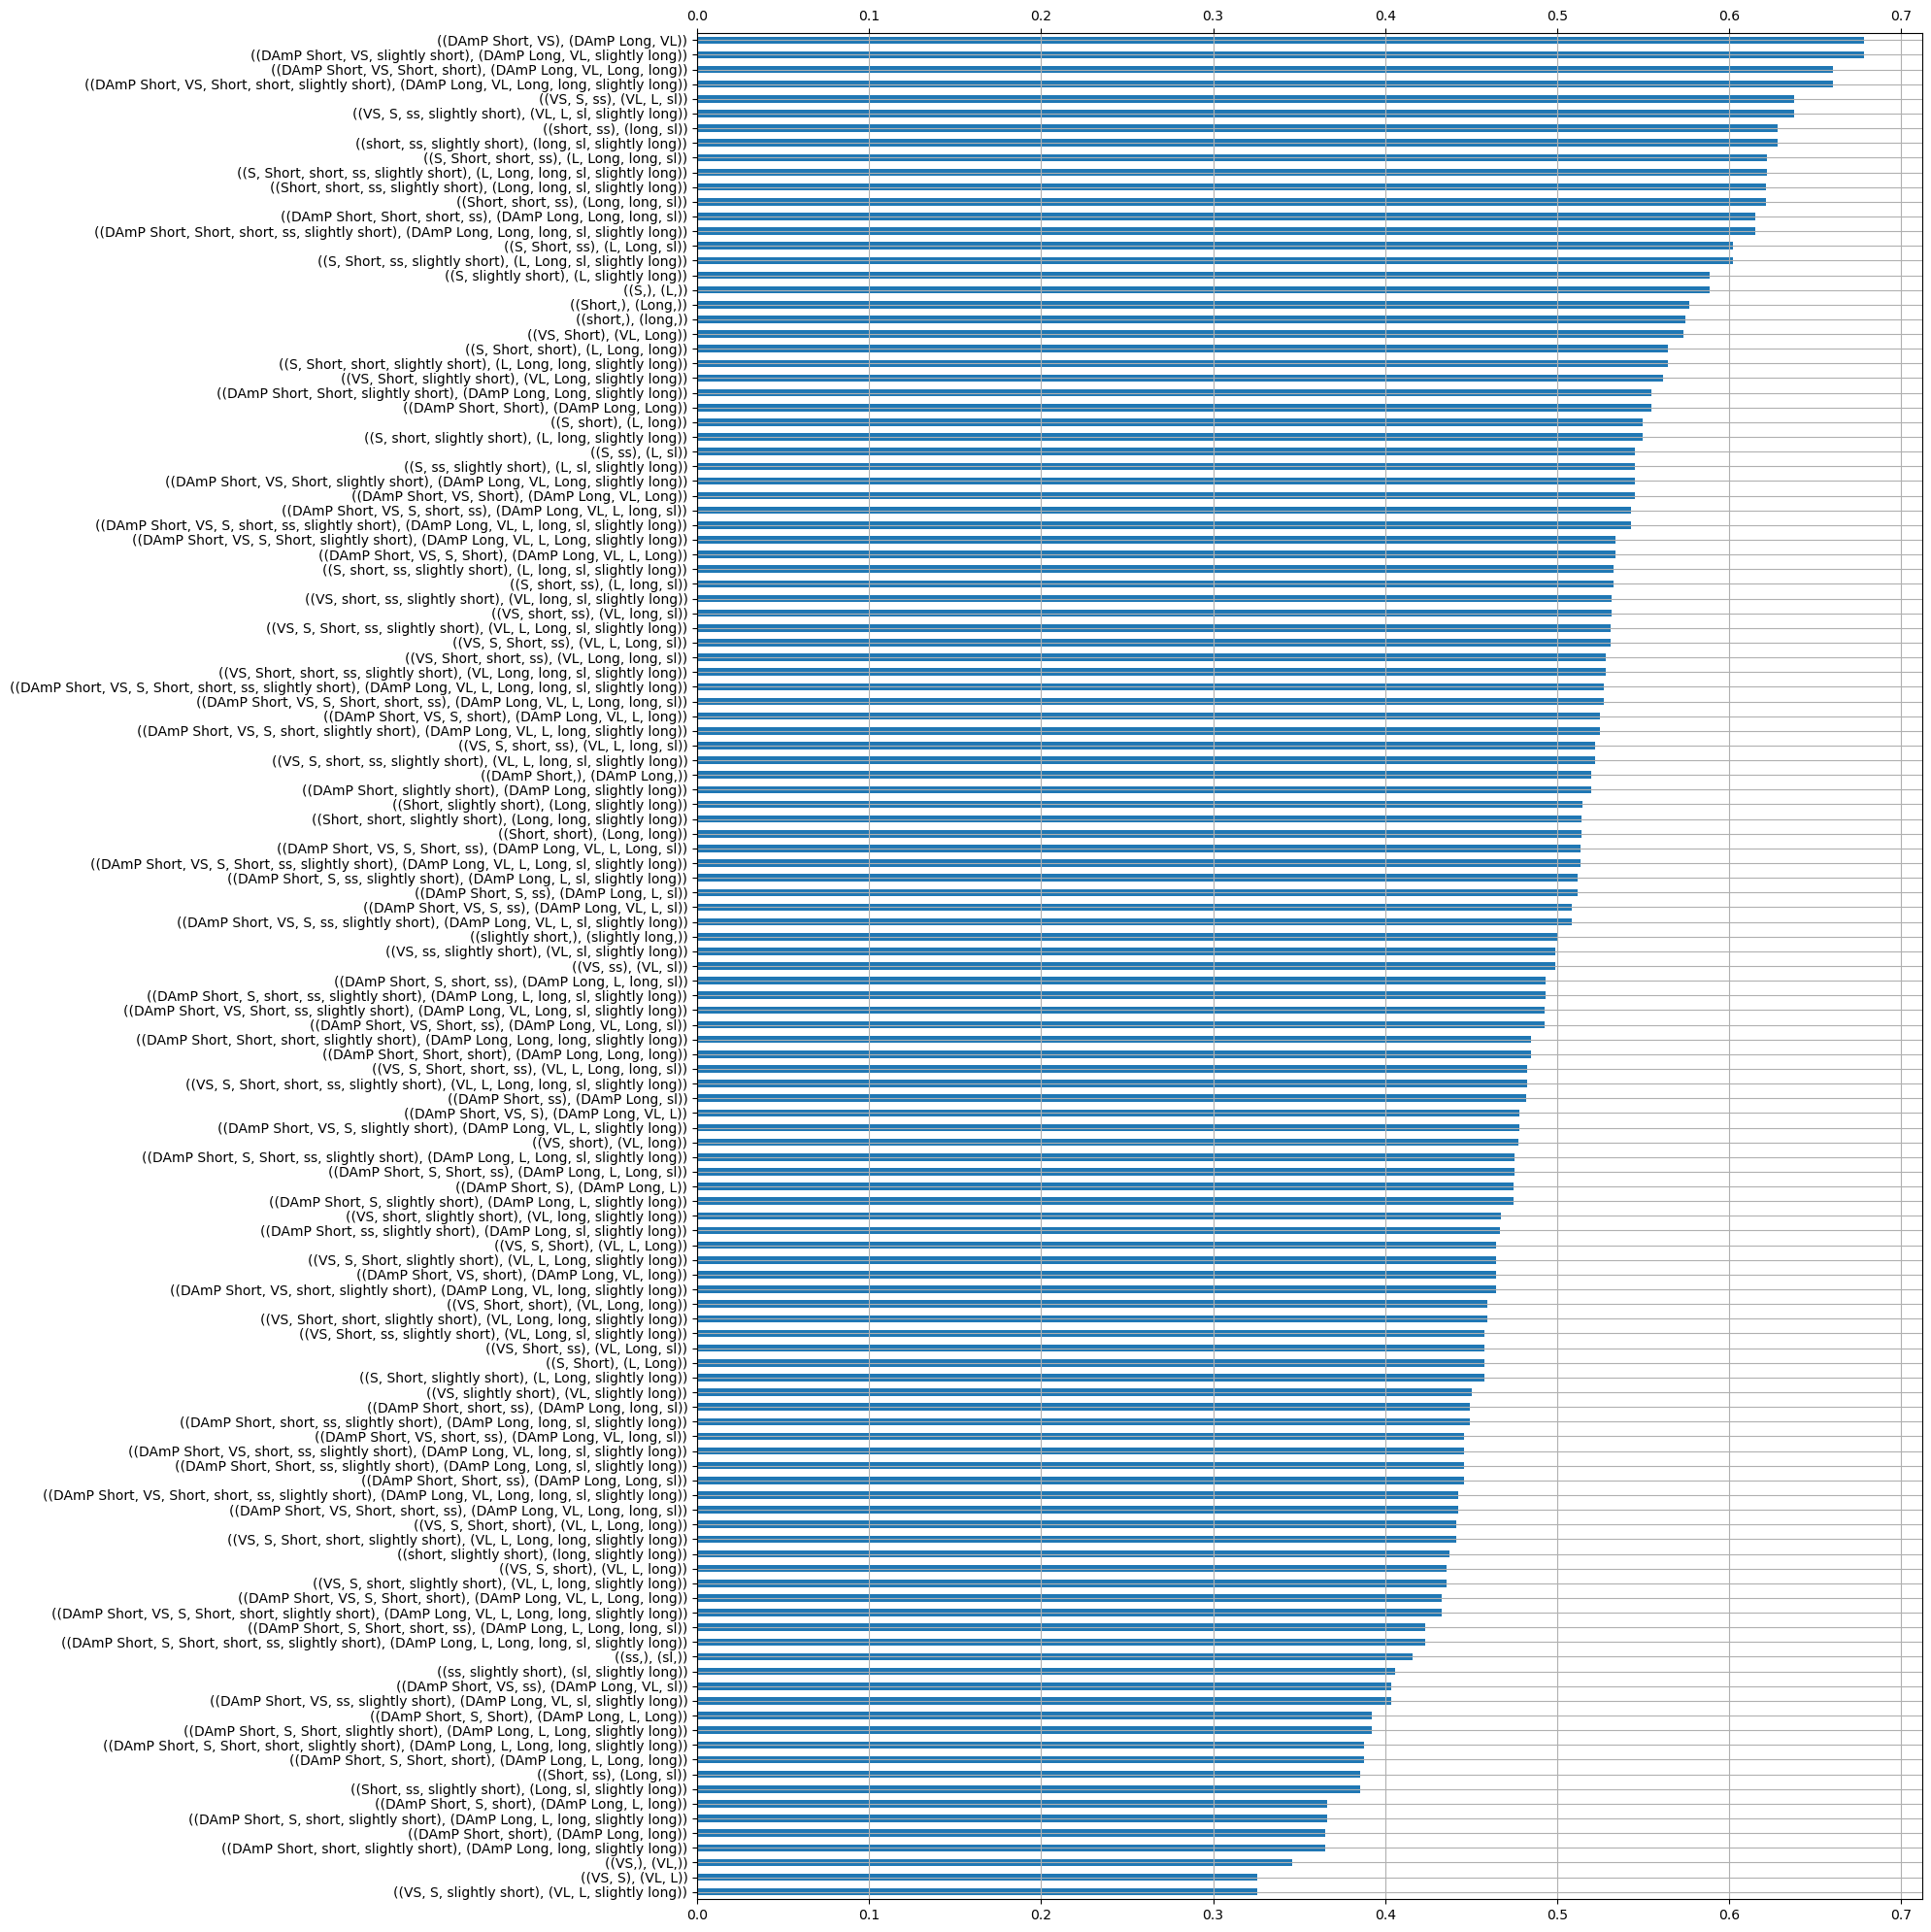

In [215]:
combos.sort_values().plot(kind='barh', figsize=(20,20), grid=True)
plt.tick_params('x', top=True, labeltop=True) 
plt.tight_layout()
plt.savefig(ANAT_VAL_OUT+'ALLPATHS_AUCs1.pdf')

In [49]:
combos.loc[(( 'S', 'VS', 'Short', 'short'),(  'L', 'VL', 'Long', 'long',))]

0.48020833333333335